## Which performance metrics from players in lower-tier football leagues are the strongest predictors of success in the Premier League, and how do these key indicators vary by player position (defenders, midfielders, and attackers)?

## **Random Forest Analysis: Attackers’ Performance Metrics as Predictors of Premier League Success**

# **Introduction**

This section explores which individual performance metrics best predict whether **attackers** from lower-tier football leagues will succeed after transferring to the Premier League. The goal is to identify the most influential indicators of success for central and wide midfield players using a Random Forest model trained on position-specific features.

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/MIT-Emerging-Talent/ET6-CDSP-group-23-repo/main/1_datasets/pre_transfer_labeled_scaled_clean.csv")

# **1. Data Preparation**

We filtered players by position **Attack** to focus on forwards and selected **domain-relevant features** reflecting attacking play: assists, chances created, crosses, dribbles, touches in opposition box, goals, and shots on target.

In [61]:
# Filter by position by "Attack"
position = "Attack"
df_position = df[df["Position"] == position].copy()

# Define domain-relevant position features for attackers
position_features = [
    "Possession - Penalties awarded",
    "Passing - Assists",
    "Passing - Chances created",
    "Passing - Successful crosses",
    "Passing - Successful passes",
    "Possession - Successful dribbles",
    "Possession - Touches in opposition box",
    "ShootingRank - Goals",
    "ShootingRank - Shots on target",
]

# **2. Model Training**
We trained a Random Forest classifier using position-specific performance features to predict whether players would be successful after transferring to the Premier League. The dataset was split into training and testing subsets to evaluate the model's ability to generalize to unseen players.

In [80]:
X = df_position[position_features + ["Player Name"]]
y = df_position["Successful"].astype(int)

# Separate player names
player_names = X["Player Name"]
X = X.drop(columns=["Player Name"])

# Train/test split
X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
    X, y, player_names, test_size=0.3, random_state=42, stratify=y
)

In [81]:
# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict & evaluate
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# **3. Model Performance: Accuracy, F1 Score, and ROC-AUC**
The model’s effectiveness was assessed with several key metrics:

    Accuracy: the overall percentage of correct predictions.

    F1 Score: the harmonic mean of precision and recall, balancing false positives and false negatives.

    ROC-AUC: a measure of the model’s ability to distinguish between successful and unsuccessful players across all classification thresholds.

These metrics together provide a comprehensive view of the model’s predictive quality.

In [82]:
# Evaluate model performance using Accuracy, F1 Score, and ROC-AUC
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Display key metrics and detailed classification results
print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.733
F1 Score: 0.500
ROC-AUC: 0.830
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.50      0.50      0.50         4

    accuracy                           0.73        15
   macro avg       0.66      0.66      0.66        15
weighted avg       0.73      0.73      0.73        15



# **4. Confusion Matrix Plot**
The confusion matrix visualizes the model’s prediction outcomes, showing the number of true positives, true negatives, false positives, and false negatives. This helps identify whether the model more accurately predicts successful or unsuccessful players and highlights areas for improvement.

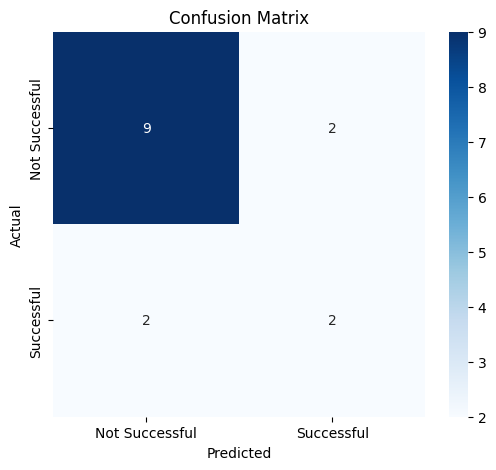

In [83]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Successful", "Successful"],
    yticklabels=["Not Successful", "Successful"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **5. Feature Importance**
Feature importance scores indicate which player metrics contribute most to the model’s predictions. Understanding these allows us to identify which aspects of a player’s performance are the strongest indicators of success in the Premier League.

In [84]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(
    ascending=False
)
print("\nFeature Importances:")
print(importances)


Feature Importances:
Passing - Chances created                 0.197567
Passing - Successful crosses              0.177554
Possession - Successful dribbles          0.128118
Possession - Touches in opposition box    0.120050
Passing - Successful passes               0.103324
ShootingRank - Goals                      0.077965
ShootingRank - Shots on target            0.065712
Possession - Penalties awarded            0.065566
Passing - Assists                         0.064143
dtype: float64


# **6. Feature Importance Bar Plot**
The bar plot provides a visual ranking of features by their relative importance. This makes it easier to interpret and compare which metrics have the greatest impact on the model’s decision-making process.

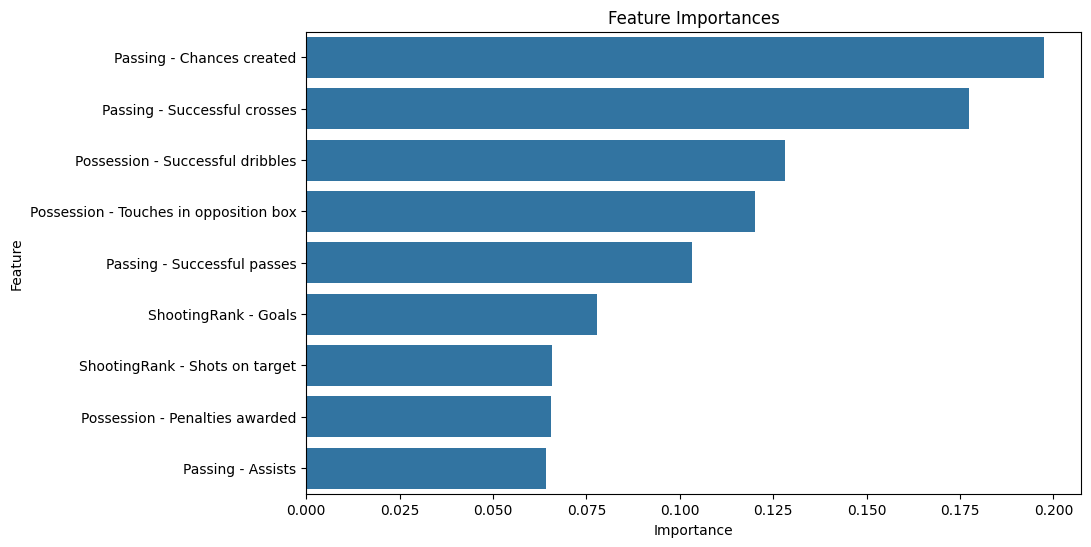

In [85]:
# Feature importance bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# **7. Analysis of Wrong Predictions**
Examining players who were incorrectly classified by the model reveals potential limitations, such as data noise or missing influential factors. Understanding these misclassifications can guide future improvements in feature selection and model design.

In [86]:
# Wrong predictions
wrong_mask = y_pred != y_test
wrong_preds = pd.DataFrame(
    {
        "Player Name": names_test[wrong_mask].values,
        "Actual": y_test[wrong_mask].values,
        "Predicted": y_pred[wrong_mask],
    }
)

print("\nWrongly Predicted Players:")
print(wrong_preds)


Wrongly Predicted Players:
       Player Name  Actual  Predicted
0  Callum Robinson       0          1
1   Arnaut Danjuma       1          0
2        Trezeguet       0          1
3  Wilfried Gnonto       1          0
